In [4]:
import pandas as pd
from numpy import nan
import numpy as np
import matplotlib.pyplot as plt

import constant

# Windmill Preprocessing
## Clean and prepare windmill data for GIS

In [6]:
# static cols
cols = ['GSRN','Turbine_type','Parent_GSRN','BBR_municipal','Placement','UTM_x','UTM_y','Capacity_kw','Rotor_diameter','Navhub_height','In_service','Out_service']

In [7]:
windmills = pd.read_parquet('data/ITU_DATA/masterdatawind.parquet', columns=cols)

In [9]:
windmills.sort_values(["In_service"])

,GSRN,Turbine_type,Parent_GSRN,BBR_municipal,Placement,UTM_x,UTM_y,Capacity_kw,Rotor_diameter,Navhub_height,In_service,Out_service
79776,571313114900743984,H,None,707,None,NaN,NaN,10.0,7.1,21.4,1816-03-29 05:56:08.067,NaT
85086,571313174116253585,W,None,265,LAND,694932.0,6175477.0,850.0,52.0,44.0,1816-03-29 05:56:08.067,NaT
85087,571313174116253585,W,None,265,LAND,694932.0,6175477.0,850.0,52.0,44.0,1816-03-29 05:56:08.067,NaT
79777,571313114900743984,H,None,707,None,NaN,NaN,10.0,7.1,21.4,1816-03-29 05:56:08.067,NaT
6507,570714700000011283,W,None,400,LAND,505771.2,6109811.3,30.0,0.1,0.1,1977-12-22 00:00:00.000,2002-11-01
...,...,...,...,...,...,...,...,...,...,...,...,...
85021,571313174002139191,H,None,336,None,NaN,NaN,5.0,2.9,3.1,NaT,NaT
85139,571313179100992129,H,None,250,None,NaN,NaN,25.0,11.0,23.5,NaT,NaT
85140,571313179100992129,H,None,250,None,NaN,NaN,25.0,11.0,23.5,NaT,NaT
85141,571313179100992129,H,None,250,None,NaN,NaN,25.0,11.0,23.5,NaT,NaT


### Filter In_service from till now

In [ ]:
windmills = windmills[windmills['Out_service'].isna()]

In [ ]:
windmills

### Remove duplicated data
Windmills have duplicated data by different reviewers.    

In [ ]:
windmills.drop_duplicates(subset = "GSRN", keep = 'first', ignore_index = True, inplace = True)
windmills.shape

9168 Contains:    
- H: Household turbine : No UTM_xy locations 
- W: Single turbine : full data
- P: Turbine park : No UTM_xy locations
- M: Turbine in a park : No power record in settlement data


In [ ]:
print('Household: ',windmills[windmills['Turbine_type'] == 'H'].shape)
print('Single: ',windmills[windmills['Turbine_type'] == 'W'].shape)
print('Park: ',windmills[windmills['Turbine_type'] == 'P'].shape)
print('In a Park: ',windmills[windmills['Turbine_type'] == 'M'].shape)

Household has no coordinates, filter it out

In [ ]:
windmills = windmills[windmills['Turbine_type'] != 'H']
len(windmills)

### Fill Turbine park xy by calculate their CENTRIODs.

In [ ]:
aggs = {'UTM_x':lambda x : x.mean(),
        'UTM_y':lambda x : x.mean()}
w_temp = windmills[windmills['Turbine_type'] == 'M'].groupby(['Parent_GSRN'], as_index = False).agg(aggs).rename(columns={'Parent_GSRN':'GSRN','UTM_x':'x_c','UTM_y':'y_c'})
w_temp

In [ ]:
windmills = pd.merge(windmills, w_temp, on='GSRN', how='left')
# location
windmills[['UTM_x']] = windmills.apply(lambda x: x[['UTM_x']].fillna(value = x['x_c']), axis=1)[['UTM_x']]
windmills[['UTM_y']] = windmills.apply(lambda x: x[['UTM_y']].fillna(value = x['y_c']), axis=1)[['UTM_y']]
windmills = windmills.drop(columns=['x_c','y_c'])
windmills

In [ ]:
windmills = windmills.drop(columns = "Out_service")

Cause a bug in ArcGIS file import, we need to add a 'z' at the end of GSRN and Parent_GSRN

In [ ]:
windmills['GSRN'] = [x+'z' for x in windmills['GSRN']]
windmills['Parent_GSRN'].fillna('',inplace = True)
windmills['Parent_GSRN'] = [x+'z' for x in windmills['Parent_GSRN']]

In [ ]:
windmills.to_csv('data/windmills_gis.csv', index=False)

## After ArcGIS data extraction 
Merge data

In [5]:
windmills = pd.read_excel('data/windmill_extract.xlsx')
windmills.head(3)

,OBJECTID,GSRN,Turbine_type,Parent_GSRN,BBR_municipal,Placement,UTM_x,UTM_y,Capacity_kw,Rotor_diameter,Navhub_height,Elevation,Slope,Aspect,grid,LandCover_Corine,LABEL3,CODE_18
0,1,570714700000001420z,M,570714700000050787z,360,LAND,628479.00,6071056.0,400.0,35.0,32.0,0.9600,2.097087,152.500809,813,12.0,Non-irrigated arable land,211
1,2,570715000000049002z,M,570715000000048869z,550,LAND,478674.48,6099264.0,600.0,42.0,45.0,12.0052,1.230658,44.436138,1190,12.0,Non-irrigated arable land,211
2,3,570714700000003837z,M,570714700000050794z,360,LAND,633430.00,6089565.0,1000.0,54.0,50.0,5.0000,1.847866,144.217468,814,12.0,Non-irrigated arable land,211


In [6]:
windmills["GSRN"] = windmills["GSRN"].apply(lambda x : x[:len(x)-1])
windmills["Parent_GSRN"] = windmills["Parent_GSRN"].apply(lambda x : x[:len(x)-1])

In [7]:
np.unique(windmills["CODE_18"])

array([112, 121, 123, 131, 133, 142, 211, 222, 231, 242, 243, 312, 313,
       321, 322, 324, 331, 411, 412, 421, 423, 512, 523])

In [145]:
# roughness_dic = {112:0.1, 121:0.1, 123:0.1, 131:0.0005,  133:0.1, 142:0.1,211:0.005, 222:0.05, 231:0.03, 242:0.3,243:0.3, 312:0.5, 313:0.5, 321:0.03, 322:0.03, 324:0.6, 331:0.0003, 411:0.005, 412:0.0005, 421:0.005, 423:0.0005, 512:0.000001,523:0.000001}

In [8]:
roughness_dic = {112:0.1, 
                121:0.1, 
                123:0.1, 
                131:0.005,  
                133:0.1, 
                142:0.1,
                211:0.005, 
                222:0.05, 
                231:0.03, 
                242:0.3,
                243:0.3, 
                312:0.5, 
                313:0.5, 
                321:0.03, 
                322:0.03, 
                324:0.6, 
                331:0.003, 
                411:0.005, 
                412:0.005, 
                421:0.005, 
                423:0.005, 
                512:0.001,
                523:0.001 
                }

In [9]:
windmills['Roughness'] = windmills['CODE_18'].apply(lambda x: roughness_dic[x])

In [10]:
windmills['Slope'] = round(windmills['Slope'],3)
windmills['Aspect'] = round(windmills['Aspect'],3)
windmills['Elevation'] = round(windmills['Elevation'],3)
windmills.fillna({'Slope':0, 'Aspect':0, 'Elevation':0, 'Roughness':0.000001}, inplace=True)
windmills = windmills.drop(columns=["LandCover_Corine", "LABEL3", "CODE_18", "OBJECTID"])

In [11]:
windmills.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6729 entries, 0 to 6728
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   GSRN            6729 non-null   object 
 1   Turbine_type    6729 non-null   object 
 2   Parent_GSRN     6729 non-null   object 
 3   BBR_municipal   6729 non-null   int64  
 4   Placement       6729 non-null   object 
 5   UTM_x           6729 non-null   float64
 6   UTM_y           6729 non-null   float64
 7   Capacity_kw     6729 non-null   float64
 8   Rotor_diameter  6260 non-null   float64
 9   Navhub_height   6288 non-null   float64
 10  Elevation       6729 non-null   float64
 11  Slope           6729 non-null   float64
 12  Aspect          6729 non-null   float64
 13  grid            6729 non-null   int64  
 14  Roughness       6729 non-null   float64
dtypes: float64(9), int64(2), object(4)
memory usage: 788.7+ KB


In [12]:
windmills.to_csv('data/windmill_cleaned.csv', index=False)

# Extract 2019 yearly max VAERDI

In [210]:
dtype = {"GSRN":str, "Turbine_type":str, "Parent_GSRN":str, "BBR_municipal":int, "Placement": str, "Capacity_kw":float, "Rotor_diameter":float, "Navhub_height":float, "Elevation":float, "Slope":float, "Aspect":float, "grid":int, "Roughness":float}
windmills = pd.read_csv('data/windmill_cleaned.csv', dtype=dtype)

In [213]:
settlement = pd.read_parquet(constant.settlement_2019_path)

In [214]:
settlement = settlement[settlement["GSRN"].isin(windmills["GSRN"].to_list())]

In [215]:
settlement

,GSRN,VAERDI,TIME_CET
0,570715000000023965,330.300,2019-01-27 19:00:00
1,570715000000023965,103.900,2019-01-27 20:00:00
2,570715000000051241,2.800,2019-04-16 15:00:00
3,570715000000023965,60.600,2019-01-27 21:00:00
4,570715000000023965,7.000,2019-01-27 22:00:00
...,...,...,...
45563225,570715000000017704,2.537,2019-12-30 21:00:00
45563226,570715000000017704,3.166,2019-12-30 22:00:00
45563227,570715000000017704,5.250,2019-12-30 23:00:00
45563228,570715000000017704,3.718,2019-12-31 00:00:00


In [216]:
settlement = settlement.groupby("GSRN", as_index=False)["VAERDI"].max().rename({"VAERDI":"max_VAERDI"}, axis=1)

In [217]:
windmills = pd.merge(windmills, settlement, on="GSRN")

### Filter max_VAERDI>0

In [ ]:
windmills = windmills[windmills["max_VAERDI"] > 0]

In [235]:
windmills["max_VAERDI"] = round(windmills["max_VAERDI"],0)
windmills[["max_VAERDI"]] = windmills[["max_VAERDI"]].apply(lambda x: round(x / 10**(len(str(int(x)))-1), 0) * 10**(len(str(int(x)))-1), axis=1)


In [236]:
windmills

,GSRN,Turbine_type,Parent_GSRN,BBR_municipal,Placement,UTM_x,UTM_y,Capacity_kw,Rotor_diameter,Navhub_height,Elevation,Slope,Aspect,grid,Roughness,max_VAERDI
0,570715000000146398,W,NaN,760,LAND,460170.090,6210725.390,3075.0,112.0,94.0,2.000,0.000,-1.000,1322,0.005,800.0
1,570715000000046605,W,NaN,550,LAND,491159.150,6103135.830,600.0,44.0,46.0,7.000,0.653,77.270,1149,0.005,100.0
2,570715000000026713,W,NaN,630,LAND,528151.659,6185719.158,660.0,47.0,45.0,97.611,3.147,135.000,1112,0.005,200.0
3,570715000000049514,W,NaN,510,LAND,529291.497,6117041.389,1300.0,60.0,46.0,46.000,2.768,145.516,1066,0.005,300.0
4,570715000000056178,W,NaN,561,LAND,474300.000,6144750.000,2000.0,80.0,60.0,2.750,2.457,267.424,1235,0.005,500.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3572,570715000000010576,W,NaN,820,LAND,524247.840,6282363.530,660.0,47.0,50.0,29.000,0.000,-1.000,1202,0.005,200.0
3573,570715000000009808,W,NaN,820,LAND,529101.410,6293551.640,600.0,43.0,50.0,24.664,3.883,153.227,1202,0.005,100.0
3574,570715000001465047,W,NaN,400,LAND,866970.000,6127812.000,2300.0,93.0,80.0,69.000,0.000,-1.000,274,0.005,2000.0
3575,570715000001465054,W,NaN,400,LAND,866800.000,6127998.000,2300.0,93.0,80.0,69.000,1.904,204.302,274,0.005,2000.0


In [237]:
windmills.to_csv('data/windmill_cleaned.csv', index=False)

## Windmill park

In [238]:
windmill_park = windmills[windmills["Turbine_type"]=="P"]
windmill_park

,GSRN,Turbine_type,Parent_GSRN,BBR_municipal,Placement,UTM_x,UTM_y,Capacity_kw,Rotor_diameter,Navhub_height,Elevation,Slope,Aspect,grid,Roughness,max_VAERDI
25,570715000000021817,P,NaN,751,LAND,576006.064000,6.239539e+06,3300.0,NaN,NaN,86.000,1.087,12.569,1032,0.005,800.0
49,570715000000035654,P,NaN,561,LAND,474056.500000,6.144843e+06,2000.0,NaN,NaN,2.000,0.000,-1.000,1235,0.005,400.0
50,570715000000023590,P,NaN,746,LAND,567319.950000,6.214403e+06,2250.0,NaN,NaN,60.000,0.586,32.931,1072,0.005,500.0
55,570715000000054594,P,NaN,480,LAND,572968.000000,6.153838e+06,1600.0,NaN,NaN,41.000,0.000,-1.000,985,0.005,400.0
84,570715000000055058,P,NaN,479,LAND,606147.500000,6.112296e+06,1800.0,NaN,NaN,87.363,2.956,199.009,899,0.005,500.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3512,570715000000064487,P,NaN,707,LAND,576787.000000,6.261446e+06,4500.0,NaN,NaN,0.000,1.392,294.105,1075,0.005,1000.0
3524,570715000000004414,P,NaN,849,LAND,544730.105000,6.354380e+06,400.0,NaN,NaN,4.000,0.000,-1.000,1206,0.005,100.0
3528,570715000000037931,P,NaN,665,LAND,450138.897500,6.253953e+06,1200.0,NaN,NaN,3.000,0.498,65.906,1367,0.005,300.0
3539,570715000000000874,P,NaN,849,LAND,513275.650000,6.327882e+06,800.0,NaN,NaN,2.000,0.000,-1.000,1288,0.005,200.0


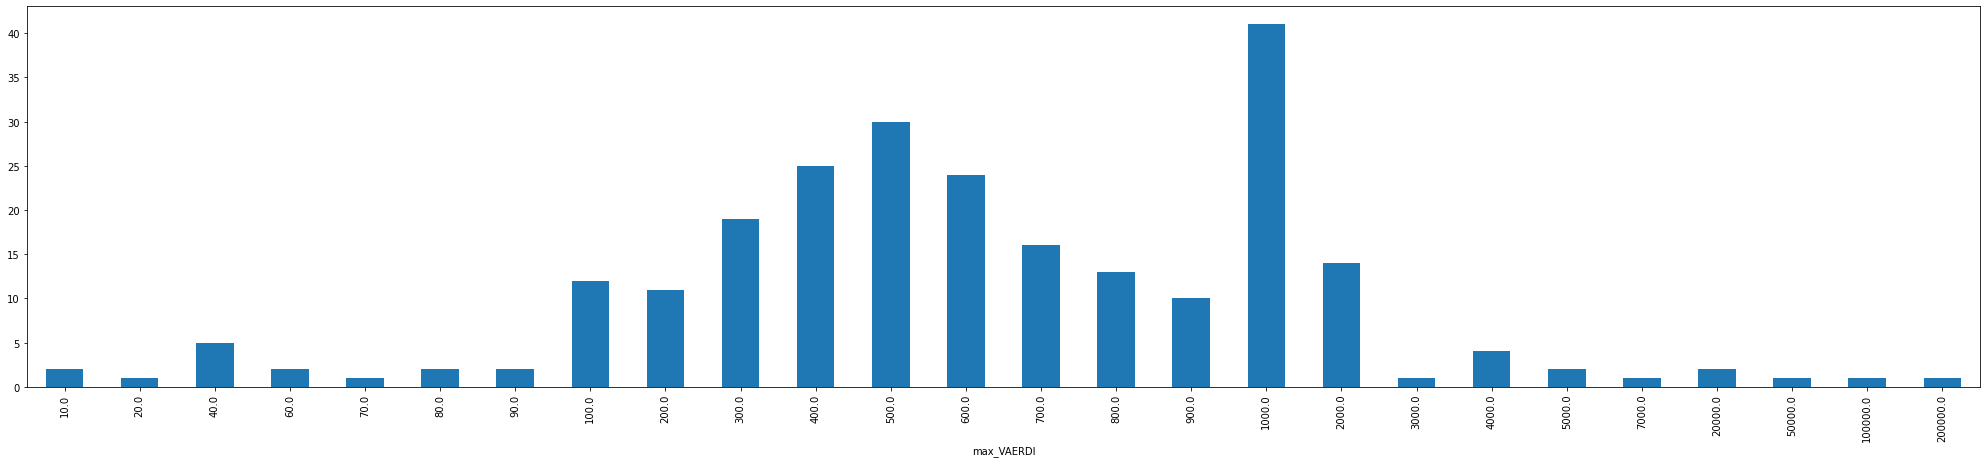

In [294]:
plt.figure(figsize=(35,7))
windmill_park.groupby("max_VAERDI").count()["GSRN"].plot.bar()

In [239]:
windmill_park.to_csv('data/windmill_park_cleaned.csv', index=False)

# Observe Land and Single

In [298]:
windmill_SL = windmills[windmills["Placement"] == "LAND"][windmills["Turbine_type"] == "W"].reset_index(drop=True)
len(windmill_SL)

3049

#### Capacity_kw distribution

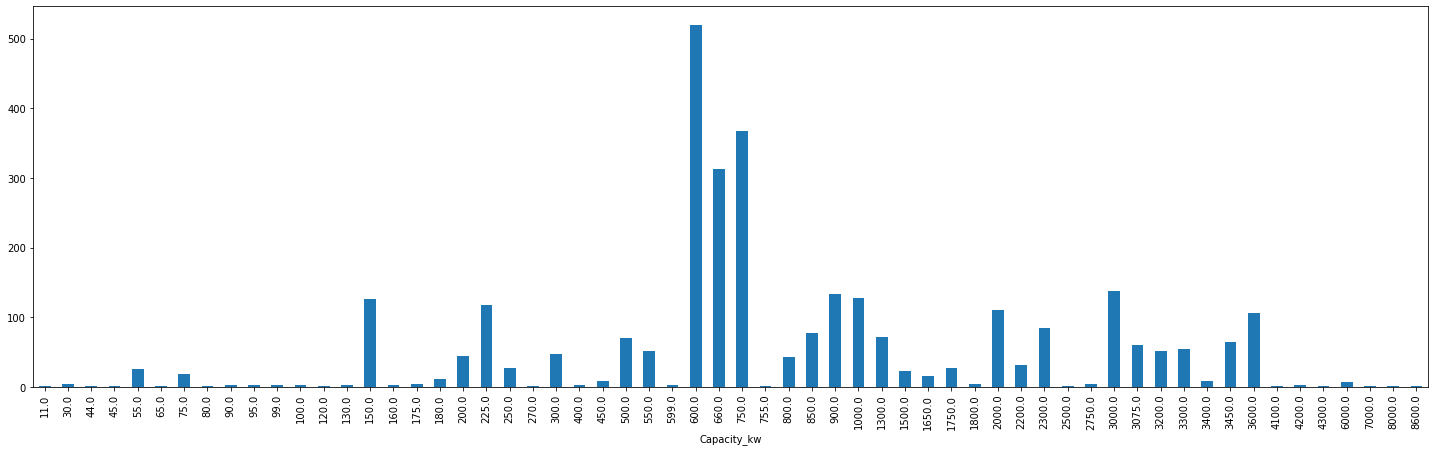

In [300]:
plt.figure(figsize=(25,7))
windmill_SL.groupby("Capacity_kw").count()["GSRN"].plot.bar()

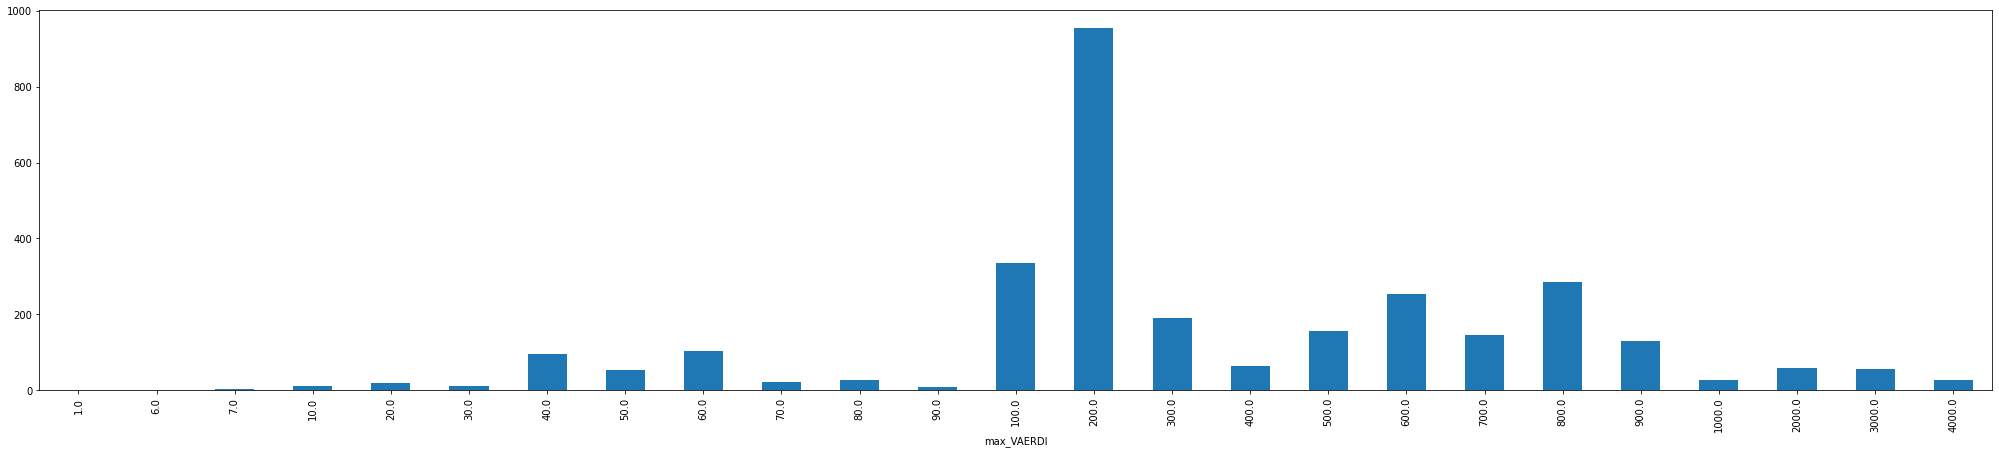

In [301]:
plt.figure(figsize=(35,7))
windmill_SL.groupby("max_VAERDI").count()["GSRN"].plot.bar()

In [279]:
from sklearn.cluster import SpectralClustering
from sklearn.preprocessing import StandardScaler
df_cls = StandardScaler().fit_transform(windmill_SL[["Rotor_diameter", "Navhub_height"]].values)
sc = SpectralClustering(25, affinity='rbf', assign_labels='discretize', random_state=0)
clus = sc.fit_predict(df_cls)  

In [280]:
windmill_SL["clus"] = pd.Series(clus)

In [285]:
windmill_SL[windmill_SL["clus"] == 4]

,index,GSRN,Turbine_type,Parent_GSRN,BBR_municipal,Placement,UTM_x,UTM_y,Capacity_kw,Rotor_diameter,Navhub_height,Elevation,Slope,Aspect,grid,Roughness,max_VAERDI,clus
3,3,570715000000049514,W,NaN,510,LAND,529291.497,6117041.389,1300.0,60.0,46.0,46.000,2.768,145.516,1066,0.005,300.0,4
41,44,570714700000014253,W,NaN,360,LAND,632425.001,6081754.134,1650.0,66.0,46.0,1.000,2.264,285.215,814,0.005,2000.0,4
42,45,570715000000032219,W,NaN,530,LAND,487563.020,6184642.910,1300.0,60.0,46.0,28.000,0.318,51.895,1237,0.005,300.0,4
53,59,570715000000044823,W,NaN,657,LAND,496145.032,6229239.583,750.0,75.0,50.0,39.998,2.386,83.192,1240,0.300,200.0,4
61,67,570715000000032332,W,NaN,530,LAND,488215.640,6185059.400,1300.0,60.0,46.0,29.000,0.000,-1.000,1237,0.005,300.0,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2798,3281,570715000000010521,W,NaN,846,LAND,572992.230,6294659.850,1000.0,60.0,45.0,3.000,0.000,-1.000,1119,0.005,300.0,4
2955,3466,570715000000010422,W,NaN,840,LAND,541751.330,6287623.120,1000.0,60.0,45.0,76.514,1.800,114.867,1160,0.005,300.0,4
2964,3475,570715000000010361,W,NaN,846,LAND,573436.820,6294411.650,1000.0,60.0,45.0,4.000,3.008,246.073,1077,0.005,300.0,4
2979,3493,570715000000010408,W,NaN,840,LAND,541776.750,6287255.790,1000.0,60.0,45.0,70.825,1.559,164.288,1160,0.005,200.0,4


### Select max_VAERDI == 200

In [302]:
windmill_SC = windmill_SL[windmill_SL["max_VAERDI"] == 200]
len(windmill_SC)

955

In [303]:
# windmill_SC.groupby(["Rotor_diameter", "Navhub_height"])["GSRN"].count() \
#                 .reset_index(name='count') \
#                 .sort_values(['count'], ascending=False)

,Rotor_diameter,Navhub_height,count
63,47.0,45.0,108
73,48.0,45.0,99
92,52.0,49.0,96
68,47.0,50.0,84
78,48.0,50.0,67
...,...,...,...
15,24.6,32.7,1
13,24.0,30.2,1
70,47.0,65.0,1
11,24.0,28.5,1


In [304]:
windmill_SC.to_csv("data/windmills_SC.csv", index=False)

## Single and HAV

In [306]:
windmill_SH = windmills[windmills["Placement"] == "HAV"][windmills["Turbine_type"] == "W"].reset_index(drop=True)
len(windmill_SH)

16

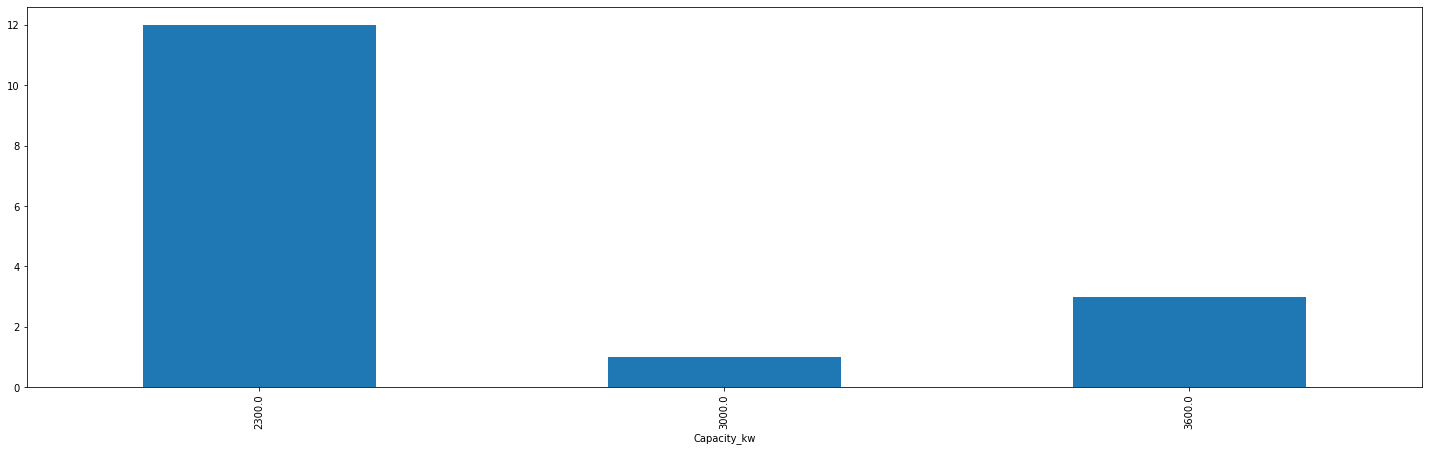

In [309]:
plt.figure(figsize=(25,7))
windmill_SH.groupby("Capacity_kw").count()["GSRN"].plot.bar()

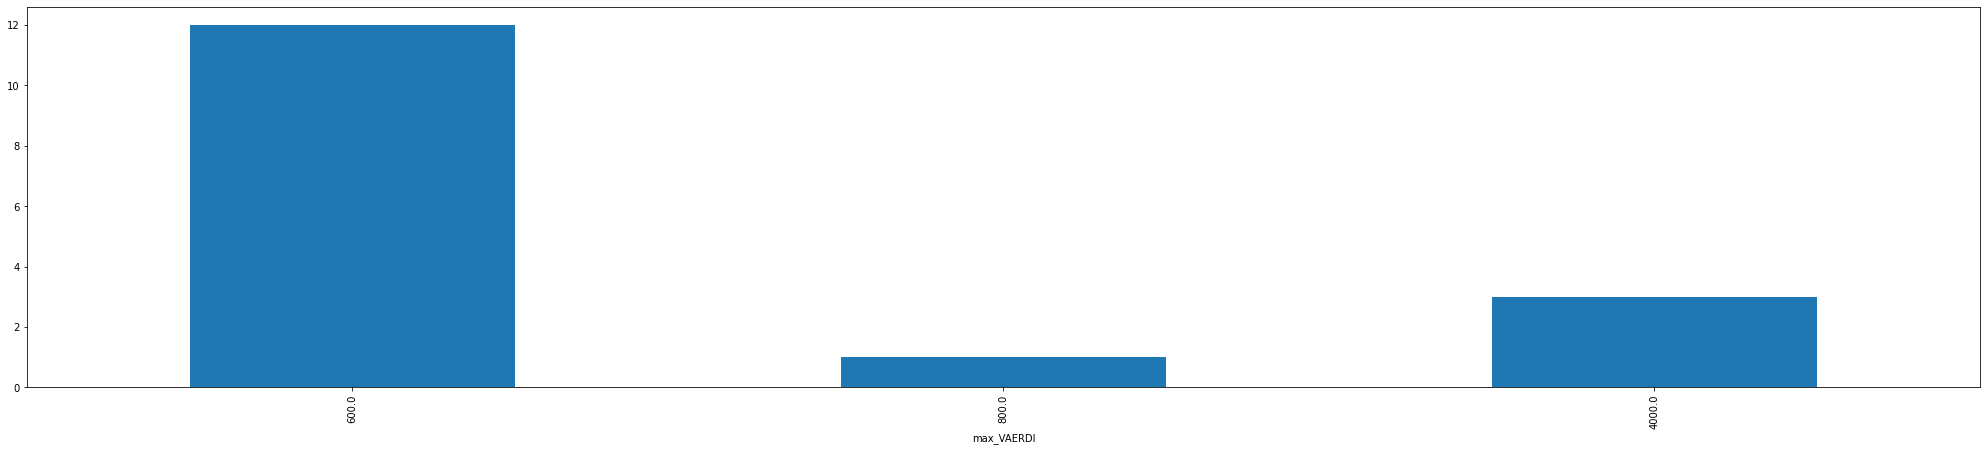

In [310]:
plt.figure(figsize=(35,7))
windmill_SH.groupby("max_VAERDI").count()["GSRN"].plot.bar()

## Park + LAND

In [311]:
windmill_PL = windmills[windmills["Placement"] == "LAND"][windmills["Turbine_type"] == "P"].reset_index(drop=True)
len(windmill_PL)

233

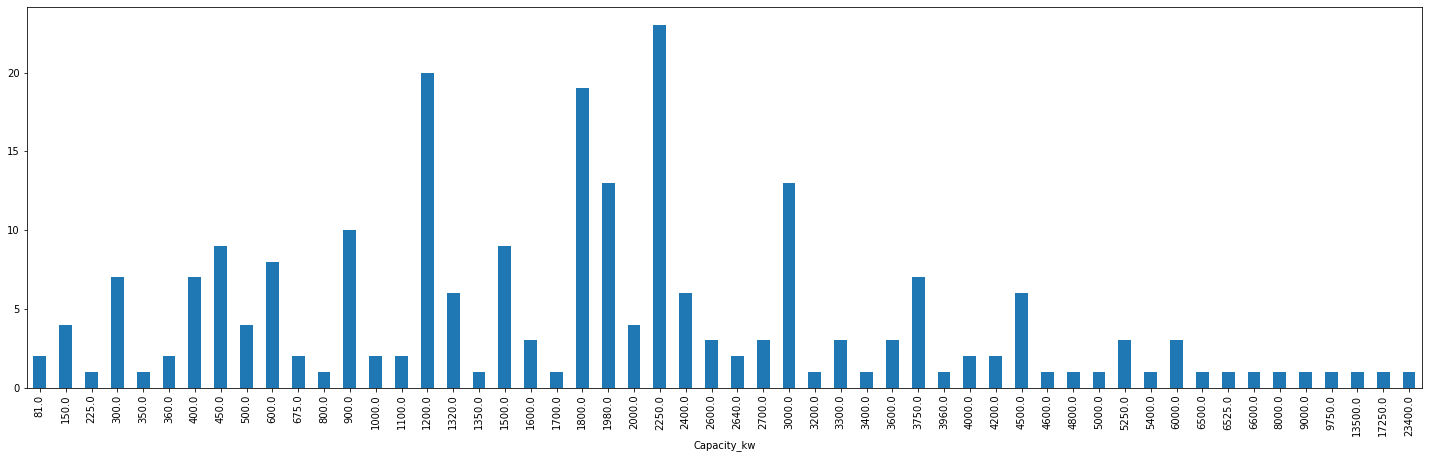

In [312]:
plt.figure(figsize=(25,7))
windmill_PL.groupby("Capacity_kw").count()["GSRN"].plot.bar()

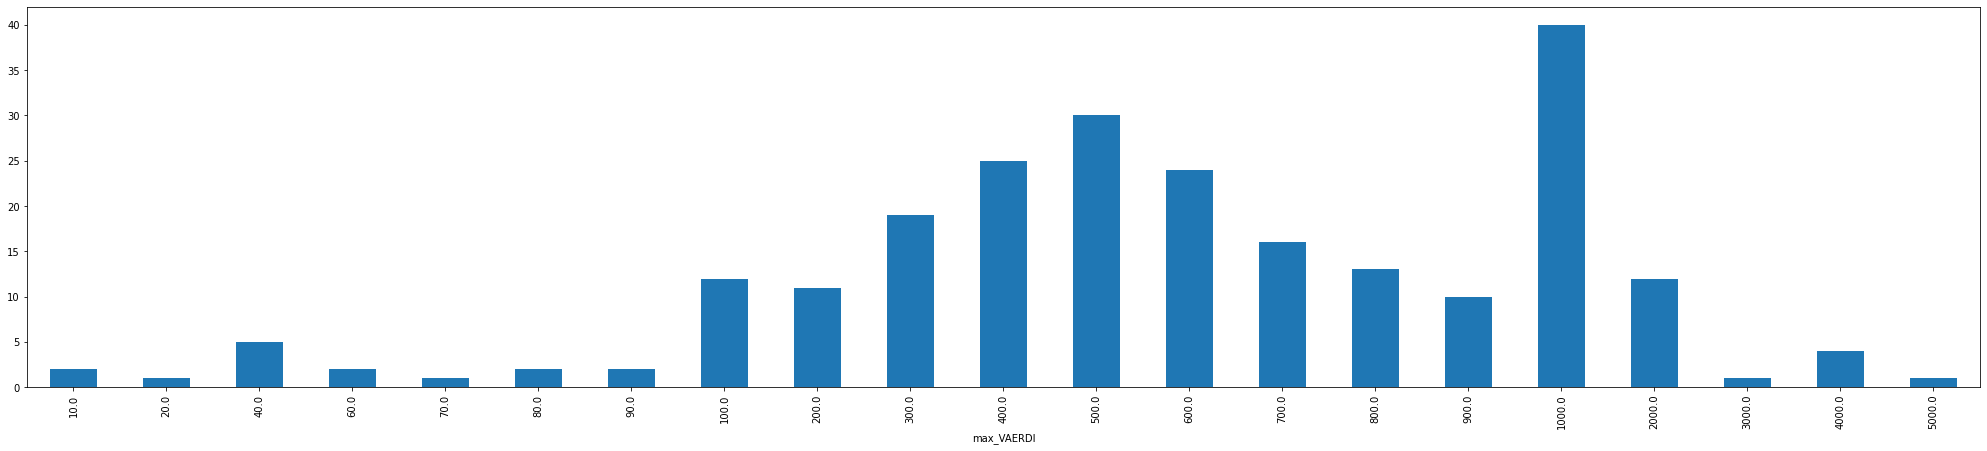

In [313]:
plt.figure(figsize=(35,7))
windmill_PL.groupby("max_VAERDI").count()["GSRN"].plot.bar()

## Park + HAV

In [314]:
windmill_PH = windmills[windmills["Placement"] == "HAV"][windmills["Turbine_type"] == "P"].reset_index(drop=True)
len(windmill_PH)

10

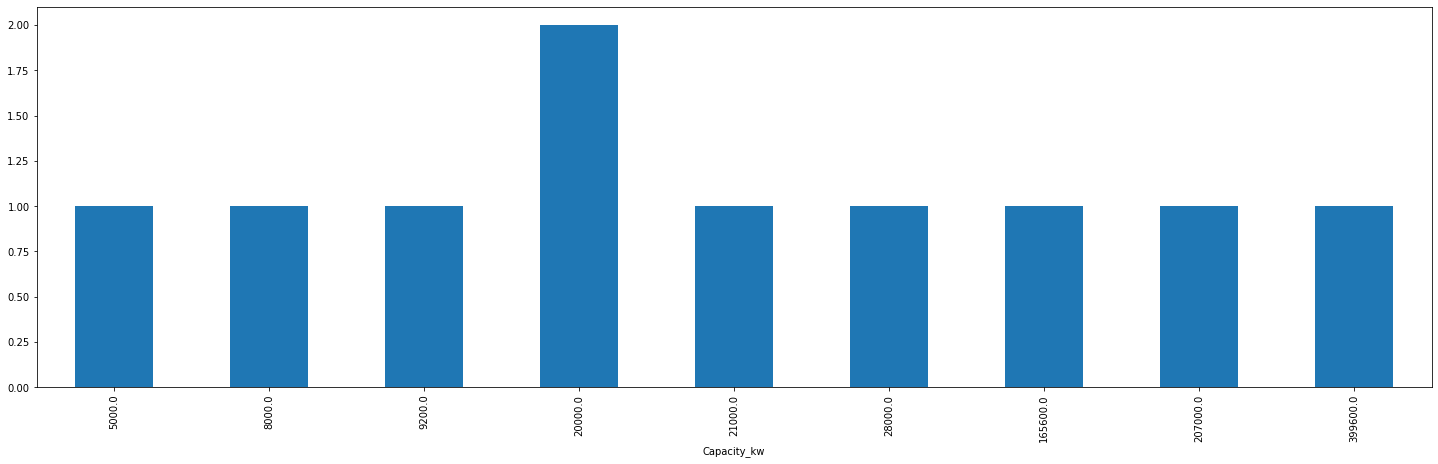

In [316]:
plt.figure(figsize=(25,7))
windmill_PH.groupby("Capacity_kw").count()["GSRN"].plot.bar()

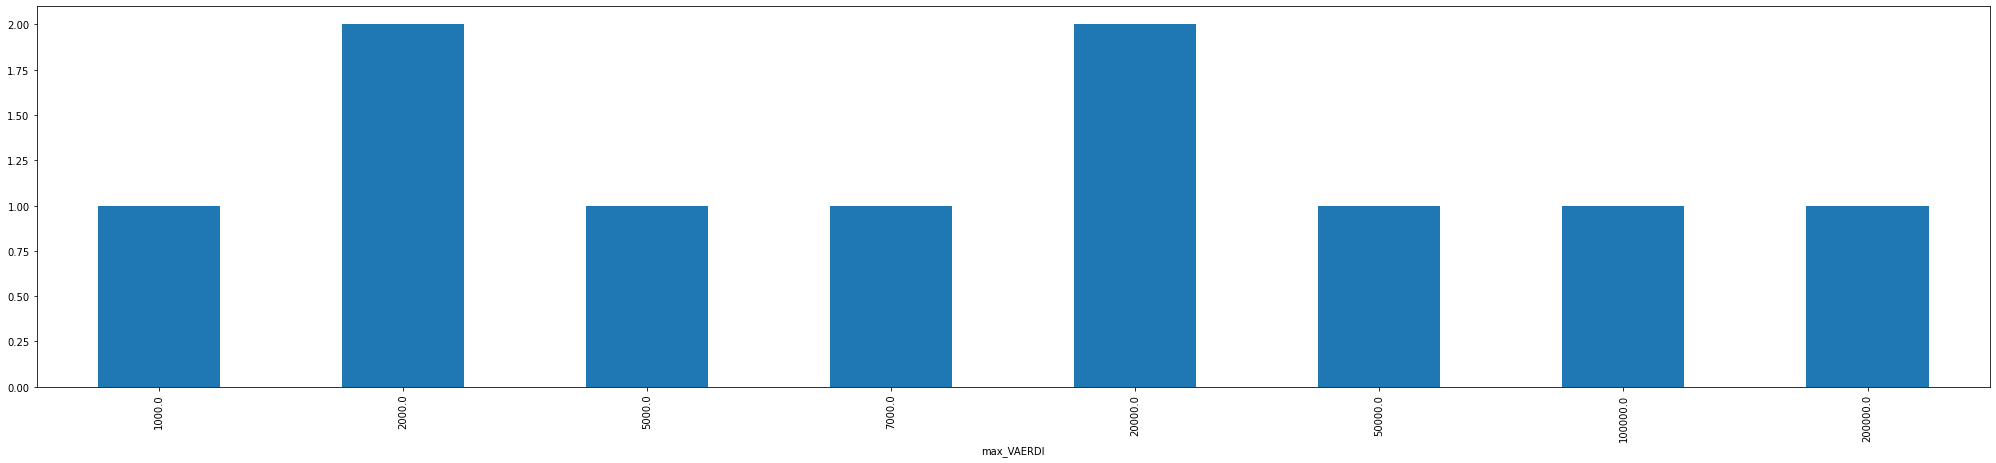

In [317]:
plt.figure(figsize=(35,7))
windmill_PH.groupby("max_VAERDI").count()["GSRN"].plot.bar()